In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=4, random_state=0)

In [3]:
x1_train = [X[i] for i in range(len(X)) if y[i] == 0]
x2_train = [X[i] for i in range(len(X)) if y[i] == 1]

In [4]:
x1_train = np.array(x1_train)

In [5]:
x2_train = np.array(x2_train)

In [6]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
#x1_train = x[0:49, :] # class A
#x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [7]:
sv = Statevector.from_label('0' * n)

In [8]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i+2], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i+4], i)

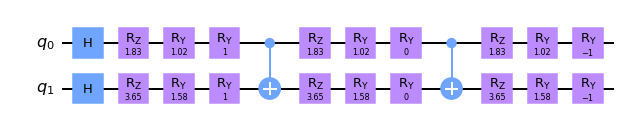

In [9]:
cir = QuantumCircuit(2)
final_circuit(cir, x1_train[0],[1,1,0,0,-1,-1])
cir.draw('mpl')

In [10]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 6# num of trainable params
for i in range(100):
    print(i)
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Data/3Layers/Layer3Easy/quantum_loss_easy_layer3blobs_%d.npy' %i
    f2 = 'Data/3Layers/Layer3Easy/opt_params_easy_layer3blobs_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

0
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823]
[0.672798273764756, 0.6646496705590925, 0.6612103725968668, 0.655543413036342, 0.6464689355881006, 0.6354893179405626, 0.6245903005942073, 0.6144952788780816, 0.6047317631354804, 0.5949415853352854, 0.5856707582844907, 0.5779830026175653, 0.5725580362550704, 0.5690243999567908, 0.5660913157081073, 0.5626357350467468, 0.5586101399033191, 0.5548135920978058, 0.5521780485732958, 0.5512423176032983, 0.5519389030315144, 0.5535609272365355, 0.5550028331984551, 0.5553502745599566, 0.5544007374870282, 0.5526460983318747, 0.5508632548278727, 0.5496873043156674, 0.5493493929971092, 0.549636020078802, 0.5500773669599753, 0.550248400352476, 0.5499631198358748, 0.5492651073437963, 0.5483081610513946, 0.54725579611113, 0.5462470501306806, 0.5453995310860079, 0.5448043277566781, 0.5445002413481288, 0.5444571194672948, 0.5445917569704525, 0.5448055930705781, 0.5450159836296081, 0.5451670575080589, 0.5452265573709042, 0.5451825

[0.8069238147264732, 0.7459432450383124, 0.6935897220498171, 0.6551534555037329, 0.6313267948589111, 0.619611370896254, 0.6162076083086826, 0.6175775365617368, 0.6211572865656074, 0.6252072912492056, 0.6284377624123791, 0.6298962175351379, 0.6290313507808691, 0.6257046168572699, 0.6201422010064236, 0.6128787160701772, 0.6046826072309368, 0.5964451271460752, 0.5890369982013933, 0.583160430400752, 0.5792285935886751, 0.5772994059215611, 0.577079766362879, 0.5780049622110274, 0.5793796344187918, 0.5805453298124882, 0.5810263296407979, 0.580611403049385, 0.5793558397740007, 0.5775191160246809, 0.5754688383594426, 0.573579481518816, 0.5721461792034819, 0.5713265762173051, 0.5711188599837637, 0.5713782921365732, 0.5718666417546334, 0.5723197148625565, 0.5725135624872594, 0.5723121491528644, 0.5716872366924617, 0.5707108297703839, 0.5695268617163076, 0.5683101771106577, 0.5672225200542287, 0.5663749630250146, 0.5658073196842469, 0.5654909134545845, 0.5653529979105115, 0.5653113598030152, 0.56

[0.8944865259406464, 0.857952287424707, 0.8265406048938175, 0.7964659002386315, 0.7651615049606666, 0.7319338868200433, 0.6981347679832024, 0.6669349973850209, 0.6405267589308604, 0.6196650434785207, 0.6042082578733315, 0.5932284303068882, 0.5855431668141563, 0.5801641071081977, 0.5762055936724577, 0.5727809174494228, 0.569239880486569, 0.5654796633111633, 0.5619226715200556, 0.55913721303816, 0.5574334159208195, 0.5567128311464389, 0.556582583559304, 0.5565274258829814, 0.5560578842250501, 0.5548588556756987, 0.5528597724157615, 0.5502235795841451, 0.5473514772545353, 0.5448705361323009, 0.543451300549038, 0.5434570276725691, 0.5446605717504479, 0.5463281836143371, 0.5476669788028121, 0.5482055903385503, 0.5478805468336554, 0.5469282653011236, 0.5457054626664417, 0.5445336060111325, 0.5436294660809154, 0.5431071970775574, 0.5429841303891444, 0.5431677934191859, 0.5434667373729756, 0.5436614670473119, 0.5436115901858419, 0.5433240573814183, 0.5429290480055933, 0.5425846791906009, 0.542

[0.7347544413582122, 0.714657531654192, 0.7007151043224531, 0.6900057870457436, 0.6818083399437844, 0.6767695635502071, 0.6745026705963656, 0.6729461095948944, 0.6700164048128844, 0.6656629295088966, 0.660767686682648, 0.6548350290304628, 0.6473831253487132, 0.6389086009367697, 0.6303907589229787, 0.6229349998006802, 0.6173628640996642, 0.6135863260331065, 0.6105224687147516, 0.6070210509037771, 0.6025048085002199, 0.5968574877113229, 0.5903156896775383, 0.5834345382257743, 0.5768740922133923, 0.5711835059736278, 0.566710385834568, 0.5635644833515204, 0.5616058684818583, 0.5605066871047564, 0.5599030255199166, 0.5595294057877517, 0.5591847776736918, 0.5585747251709696, 0.5573239374914728, 0.5552690746210321, 0.5526215975795014, 0.5498326981068373, 0.547429441082602, 0.5458885699664444, 0.5454646848242337, 0.5460278787809157, 0.547078666992989, 0.5479704269499143, 0.548213543699545, 0.5476921982854126, 0.5466696270927083, 0.5456063671889992, 0.5449187823112629, 0.5447955865580422, 0.545

[0.7793909158840393, 0.7577872713568803, 0.737488131072707, 0.7180458389952222, 0.6996828546395267, 0.6847887222541437, 0.6729469883172918, 0.660460558970746, 0.6443542672667081, 0.6264702002888357, 0.6099806221025091, 0.5967386769890878, 0.5873636607847653, 0.5812343264304903, 0.5769371446338379, 0.5734434678374246, 0.5705373469348272, 0.5682323480098945, 0.5664055635367563, 0.5647698168349187, 0.5629791713933047, 0.5608240033682563, 0.5583637159668182, 0.5558694006533346, 0.5536419308129953, 0.551872494767126, 0.5506091124909789, 0.5497667837882978, 0.5491458014371652, 0.5484820922604796, 0.5475375410660146, 0.5461883791645917, 0.5444605289569767, 0.5425164433879348, 0.5406244362837888, 0.5390938005053578, 0.5381343275236422, 0.5376980884816264, 0.537478741072695, 0.5371211266008605, 0.5364412614382593, 0.5354867071619196, 0.5344671657061658, 0.5336402552891744, 0.5331989631160252, 0.5331875138891993, 0.5334731501913516, 0.5337944477988789, 0.5338778924798988, 0.5335645567926529, 0.5

[0.7207150910712536, 0.7016119453205282, 0.6896872325454828, 0.678687763299743, 0.6664127188852046, 0.6548049462168748, 0.6451223908511987, 0.6372045448840117, 0.6312541099458095, 0.6277984847960224, 0.6264492569016847, 0.6262579256812628, 0.6265044454683868, 0.626863793401125, 0.6272742212201794, 0.6277352601980192, 0.628153284006843, 0.6283539220372771, 0.6282141643131969, 0.6277459299189964, 0.6270576873729944, 0.6262620506507568, 0.6254082477639432, 0.6244705217389545, 0.6233852833951844, 0.6221087637584222, 0.6206618967412385, 0.6191378234801963, 0.617669465454257, 0.6163744722154371, 0.6153042424116042, 0.6144199392286951, 0.6136107863364069, 0.6127513859835553, 0.6117603792317668, 0.6106060775949393, 0.6092450116860763, 0.6075418931338588, 0.6052315273056628, 0.6019514832739546, 0.5973451386785233, 0.5911927280314523, 0.5834615543993952, 0.5743372648092852, 0.5644947687962673, 0.5553702160374776, 0.5488478066405493, 0.5462127234582296, 0.5470850421433527, 0.5497315596630228, 0.5

[0.7875538929487357, 0.7622219102751902, 0.7361727126352506, 0.7101405925558262, 0.6892368593176541, 0.6751616377366091, 0.6666789231637376, 0.6616562915095363, 0.6570560402357302, 0.6499454448960463, 0.640044288080426, 0.629259420688269, 0.619111825088789, 0.6101432912101161, 0.6024503876534221, 0.5959564697431662, 0.5903935992444748, 0.5854018875867221, 0.5807660560991985, 0.5765335181848306, 0.5729362011640996, 0.5702337556049945, 0.5685870422030948, 0.5679903546783653, 0.5682527779282844, 0.569031514483699, 0.5699214687246927, 0.5705708625595842, 0.5707722299284381, 0.570494364838106, 0.5698375850085337, 0.5689262160302015, 0.5678095833073822, 0.5664455857590327, 0.5647686307682662, 0.5627743096086827, 0.5605564605181139, 0.5582838024132147, 0.5561450100221121, 0.5542962853337445, 0.5528306566561314, 0.5517719890415299, 0.5510869166964053, 0.5507047188735583, 0.5505372458896641, 0.5504948938745299, 0.550498181298925, 0.5504849802388394, 0.5504136330852927, 0.550260909630631, 0.5500

[0.6756223300528983, 0.6690613673995536, 0.6643821110295355, 0.6570836546640396, 0.6463246408389751, 0.6338795827659758, 0.6228344533267914, 0.6133994790561151, 0.6037144888706198, 0.5937475847028645, 0.5839462356313304, 0.5748513807852969, 0.5672908837675753, 0.5622459564388165, 0.5603338261344818, 0.5612840720995084, 0.5636405600178347, 0.5652000172381214, 0.5645935625236748, 0.5619298835941815, 0.5581505203268099, 0.5542571378741242, 0.5509019890894372, 0.5485469691025086, 0.5474925919967054, 0.5475922530455456, 0.5482150942437031, 0.5486614179137466, 0.5485981343093391, 0.5481501158102964, 0.5476859195594865, 0.5475124816506737, 0.5476595786225703, 0.5478865646757614, 0.5479020935943942, 0.5475830541514006, 0.5470228745069565, 0.5464403039849863, 0.5460454011959148, 0.5459304246261786, 0.546032469550702, 0.546182332823176, 0.5462037569766963, 0.5460001569015912, 0.545588318984916, 0.545077724029046, 0.5446145508288854, 0.5443141952306463, 0.5442101281547024, 0.5442450889643774, 0.5

[0.673348107591383, 0.6534713239820011, 0.6399908940163023, 0.6330595915906201, 0.6315216534809559, 0.6324039557342795, 0.6332320776541898, 0.6329795020976055, 0.6316251120815957, 0.6294798658548747, 0.6268752208621063, 0.6242482794305743, 0.6220736018881314, 0.6205669931835961, 0.619522487615683, 0.618496368325083, 0.6170836388343112, 0.6150213606374014, 0.6121794225372924, 0.6085025761417271, 0.6039534058045786, 0.5984870549924848, 0.5920227957065739, 0.5843790376551697, 0.5753708225810054, 0.5653928238648717, 0.5558915801142126, 0.5488231810812064, 0.5454158227264795, 0.5455448215667261, 0.5480555860084603, 0.5514887195141539, 0.5547172967574773, 0.5569250918329335, 0.5576166959557077, 0.5569173063532465, 0.555449182808999, 0.5538937004658974, 0.5526228253922861, 0.5516278658450666, 0.5507847980573919, 0.5500157819882685, 0.5491998247054433, 0.548192793025685, 0.5470530080840951, 0.546145690436495, 0.5458109284240154, 0.5459646156200862, 0.5462081634445605, 0.5462438464530345, 0.546

[0.8062240784006781, 0.788644711590499, 0.7739578833126365, 0.7597301709953822, 0.743815747531775, 0.7250144755949985, 0.7042732838187438, 0.6830498335539583, 0.6626369558034156, 0.6446007761336182, 0.6307545448800862, 0.6221515323169673, 0.6182964319627384, 0.6173068816766369, 0.6169534293654404, 0.6156915015672896, 0.6128946126926451, 0.608495887586907, 0.6026482604497961, 0.5956759602464343, 0.5881586968683105, 0.5808598692749576, 0.5744840083138482, 0.5694880239183635, 0.5660262363928771, 0.5639748120858791, 0.5630273712068322, 0.5628468982347345, 0.5631740246375988, 0.5638043502313967, 0.5645050974429918, 0.5650080030978062, 0.5650913636780741, 0.5646569050969077, 0.5637378998130405, 0.5624507832956813, 0.5609411185690084, 0.5593550224260064, 0.5578298138580063, 0.5564787551591697, 0.5553646043350806, 0.5544808512978096, 0.5537580034150804, 0.5530919740031881, 0.5523835549139742, 0.5515754732700507, 0.5506695691845901, 0.5497139517203145, 0.5487707772255278, 0.5478879084923318, 0.

[0.8113691163621481, 0.7807003140142501, 0.757859204484412, 0.742573964734678, 0.7302197382602984, 0.7165884139571408, 0.7001654195450544, 0.6805285091587944, 0.659330498836838, 0.6397402207869091, 0.6241994052595348, 0.6138963455762685, 0.6090691751895903, 0.6088411162144781, 0.6111912067156465, 0.6138403456833047, 0.6152935120616669, 0.6151226682168649, 0.6136500346654414, 0.6115079455801871, 0.6093014967471049, 0.6074234666600051, 0.6060064736987554, 0.6049724904822132, 0.6041353287915282, 0.603307864042862, 0.6023705076865863, 0.6012807216886775, 0.6000410321153017, 0.598661292468077, 0.5971401024360252, 0.5954690333409528, 0.5936494101100518, 0.5917080855234588, 0.5897017090419068, 0.5877074014554377, 0.5858039138841937, 0.5840540557483973, 0.5824971679795774, 0.5811527671550166, 0.5800253155831008, 0.5791005434747241, 0.5783306679416951, 0.5776144782571623, 0.5767810778041673, 0.5755934646345279, 0.5737965096587666, 0.5712133239036312, 0.5678188542350654, 0.5637062626322257, 0.55

[0.7634489349232808, 0.7247915092479364, 0.696198710795781, 0.6773092135718985, 0.665837019947528, 0.6566877242927264, 0.6468134844414729, 0.6367398170357299, 0.6268067787147409, 0.6167408293261321, 0.6066135173108329, 0.5967764610132933, 0.5875401814141789, 0.5793851901428774, 0.5728458405507323, 0.5681854374717471, 0.5653753391404728, 0.564219107792793, 0.5644114489877416, 0.5655357914584886, 0.5670919983861575, 0.5685952759243796, 0.5696905652288813, 0.5701992347821956, 0.57008257203749, 0.5693720315267133, 0.5681263923937966, 0.5664474381000787, 0.5645255858900498, 0.5626340499034466, 0.5610333573322641, 0.5598602071328715, 0.5591004213893314, 0.5586481710214681, 0.5583740067659172, 0.5581503094644983, 0.5578524568750409, 0.5573742103940886, 0.5566631908552423, 0.5557469904574619, 0.554719397141964, 0.5536856141966948, 0.5526969089288428, 0.5517162307861431, 0.5506432744242563, 0.5493924483292737, 0.5479799249596583, 0.5465606119259762, 0.545379326927, 0.5446545103972229, 0.5444600

[0.784256084876563, 0.7415198450810556, 0.716944384885101, 0.7044074965825735, 0.6980355259306537, 0.693797949500723, 0.690532139562402, 0.6878084312474609, 0.68456454255825, 0.6797753634891354, 0.6735949513110705, 0.6669569210597254, 0.6606557502467441, 0.6549600879852774, 0.6495314933940262, 0.6438484361655612, 0.637947474622232, 0.6322137587531138, 0.6266603362999676, 0.6208990919213059, 0.614508616861331, 0.6071244325252033, 0.5983183507562848, 0.5879558119134299, 0.5768437174087621, 0.5664774103005923, 0.5581683344562716, 0.5526156066358453, 0.5499265366187928, 0.5496907977306537, 0.550937382655983, 0.5521959950151499, 0.5523658796362764, 0.5516633830393887, 0.5509248088694215, 0.5506473046719558, 0.550824148029546, 0.5511139219440706, 0.5510514765737647, 0.550229442701333, 0.5484162322932807, 0.5455989534976047, 0.5419633312088611, 0.5378337502384027, 0.5335912807114838, 0.5295848382207656, 0.5260582443239653, 0.5231163679831482, 0.5207362547863812, 0.5188123165588576, 0.51721386

[0.798674700186518, 0.757024220951117, 0.7227244600804517, 0.6972454128792502, 0.6805018071379756, 0.6705728569149801, 0.6642375636925019, 0.6588265390511325, 0.6527931294324024, 0.6451794067871656, 0.6351854335353534, 0.6230803548732956, 0.6106955509807658, 0.5996958032592267, 0.5904372370049008, 0.5824394244761743, 0.5754197102339977, 0.5695097494430847, 0.5649674767641261, 0.5619819474392805, 0.5605719167046255, 0.5605275006996517, 0.561423802234315, 0.5627372254980638, 0.5640124290041314, 0.5649675928755626, 0.5654945366298094, 0.5656016663783806, 0.5653502112135607, 0.5648040976234402, 0.5639975563639557, 0.5629302880018322, 0.5615953376180456, 0.5600203477504511, 0.5582859377842231, 0.5565027765762406, 0.5547639684801823, 0.5531102506639527, 0.5515334122138502, 0.5500131771582994, 0.5485585193092745, 0.5472269414037555, 0.5461132226881029, 0.5453165369499382, 0.5449030294696642, 0.5448796477348187, 0.5451868343710005, 0.5457094976364745, 0.5463013966237095, 0.5468155874534846, 0.

[0.6956214210070593, 0.6589915434366528, 0.6358841089037082, 0.6241205447460257, 0.6194637399188967, 0.6177867409047967, 0.6161397330996512, 0.6123910330682698, 0.6056828623537771, 0.5967892779556329, 0.5872970298904404, 0.5786898172221426, 0.5720121748807654, 0.5677171207109365, 0.5654755228246967, 0.564313749543062, 0.5633723593196213, 0.5624542793458818, 0.5618094457179224, 0.5617097070076579, 0.562212447647, 0.5631390337053876, 0.5641775876172633, 0.5650128611494822, 0.5654200722687325, 0.5653029426826117, 0.5646869593178825, 0.5636881471035008, 0.5624700055301541, 0.5611941638596312, 0.5599721768154486, 0.5588356926724452, 0.5577457727531615, 0.5566416191443738, 0.5554924845587281, 0.5543100648976079, 0.5531209709517878, 0.5519377281006767, 0.5507587502593062, 0.5495939524019826, 0.5484910949129066, 0.5475374752753244, 0.5468296498649168, 0.546426843957199, 0.5463157185345922, 0.546407467840783, 0.546568386243239, 0.5466701568960497, 0.5466344477345565, 0.5464479373966, 0.54614208

[0.7140856359368667, 0.6835061938242127, 0.6621081054818327, 0.6466651745162454, 0.6365143095764239, 0.6303084112565209, 0.6244372046584357, 0.6174245068980406, 0.610054639128018, 0.6027652403447058, 0.5954220898574278, 0.5882898599953176, 0.5823601308315941, 0.5785433309165929, 0.5768630509659682, 0.5765222738778625, 0.576659668934759, 0.5767915785016485, 0.57672492656569, 0.5763503545030632, 0.5755274421417184, 0.5741041696508388, 0.5720220802225099, 0.5693964419282723, 0.5665086452342901, 0.5636904442664489, 0.5611401066735006, 0.5587613034894935, 0.556104017389333, 0.5525137864827413, 0.5474086949667997, 0.5404373645103844, 0.5316578762489236, 0.5217645563894314, 0.5119440789900142, 0.5034263216452257, 0.4971371989903321, 0.49348890568375553, 0.4922548497016949, 0.49271470332443174, 0.49407655250764854, 0.4957241502698666, 0.4971860189663612, 0.49812608582457407, 0.49837319787722945, 0.49788635289912725, 0.4967027664189611, 0.4949474956599106, 0.49286730345436924, 0.490798160111093

[0.755004151798383, 0.721646433214949, 0.697633558800125, 0.6838716984556773, 0.6790525409857906, 0.6796524129432961, 0.6814947180874763, 0.6820446533714352, 0.6810545087344512, 0.6795271344138328, 0.6782965899813065, 0.6774676153666991, 0.6766658589280609, 0.6754599207050748, 0.6735966715241605, 0.6711359501505936, 0.6685058611618689, 0.6661839654166803, 0.6642313854591987, 0.6623262722472919, 0.6601918076693302, 0.6578419318980988, 0.6554951145290575, 0.6533862506002448, 0.6516416683291253, 0.6502212684191292, 0.6489131808747534, 0.6473953713657942, 0.6453439083052753, 0.6425102024289738, 0.6387242708253867, 0.6338682837844772, 0.6279005588832536, 0.6209326169366873, 0.6131946363562621, 0.6047737227861998, 0.5956646645617383, 0.5863841117620934, 0.5777104086595752, 0.569918274653934, 0.5630051596199194, 0.5572841918927677, 0.5534776438738132, 0.5521964069187316, 0.5531209943852834, 0.5548374788880419, 0.5561804909709591, 0.5569130492755132, 0.5570028486936908, 0.5563708052517178, 0.5

[0.8114774335252035, 0.7823568699978973, 0.7547565708254451, 0.724122374643448, 0.6911968426655658, 0.6582785050084674, 0.6278381636184824, 0.6024607877569952, 0.5844420855819891, 0.5749570475400518, 0.5733220673804229, 0.5770373200642365, 0.5829795054202501, 0.5886556892445309, 0.5926352400308108, 0.5944583628967497, 0.5943364724201347, 0.5927780116158539, 0.5902387721646372, 0.5869101407961028, 0.5827110233231267, 0.5774328282566139, 0.570921950364689, 0.5632233720861434, 0.5546582335838428, 0.5458067876612791, 0.5373717771965457, 0.529940027716641, 0.5237444955086497, 0.5185917580127644, 0.5140389429771598, 0.5096908752551798, 0.5053823171719997, 0.5011703405453918, 0.49724746335283876, 0.4938642226178039, 0.4912573539874093, 0.4895662950386288, 0.48876408097497526, 0.48865083205193693, 0.48892946548669974, 0.4893263024430943, 0.4896846734832407, 0.48998143577829656, 0.4902717867110206, 0.490607247541347, 0.49097527736923724, 0.4912878990451421, 0.49141795355053725, 0.49125764409705

[0.7128071291410533, 0.6893511500288605, 0.6764375000816559, 0.6714724485535756, 0.6695715978014272, 0.6682329001307149, 0.6665807656554773, 0.6642779559607607, 0.6609791967524871, 0.6563944448082286, 0.6505088237965707, 0.6435281652892307, 0.6358905145145199, 0.6281596632760124, 0.6207046009327353, 0.6134918456155464, 0.6061296273997007, 0.5981429951753493, 0.5895589004997293, 0.5811965702938849, 0.5739748584998341, 0.5681877348739226, 0.5635794374294053, 0.5597393012871128, 0.556328908199601, 0.5531787978427637, 0.5504372145160553, 0.5486558825350099, 0.5483886837877165, 0.549620009687379, 0.5516745427138767, 0.553613849986247, 0.5547040406854863, 0.5546251879636777, 0.553387010783158, 0.5510752261128465, 0.5476228703767586, 0.5429112428986206, 0.5373829756634902, 0.5322814550760444, 0.5287090905734143, 0.5268859227299872, 0.5262763578250398, 0.5259999108274835, 0.5252465991416273, 0.5236234901550395, 0.5212488073027163, 0.5185642282562132, 0.5160701826319255, 0.5141445771350849, 0.5

[0.7243774798037039, 0.7061949352926769, 0.6911725247896767, 0.6803396951265254, 0.6725621350023555, 0.6638875186118796, 0.6537313475675134, 0.6464836529580578, 0.642356350908504, 0.6390654377865256, 0.6334512184383602, 0.6247346457106969, 0.6149252060932072, 0.606679889064974, 0.601067590299913, 0.5971013819745571, 0.5933037783164384, 0.589000607588104, 0.5842286329273579, 0.5793403474404798, 0.5747438095978148, 0.5707877658468473, 0.567731962681949, 0.5657083771742311, 0.5646672452604262, 0.5643872435289119, 0.5645678463024509, 0.5649213964144806, 0.5651951483411215, 0.5651560888814848, 0.564632469659368, 0.5636371776598321, 0.5624113112691151, 0.5612336172310477, 0.5601762798092982, 0.5591009725621461, 0.5578735513680555, 0.5565106267808212, 0.5551361973982017, 0.5538722965441666, 0.5527871068759205, 0.5519112817569163, 0.5512555851622556, 0.5507786409095088, 0.5503442451930097, 0.549752174400009, 0.5488566090421587, 0.5476797189523878, 0.5464187771718052, 0.5453434315033874, 0.5446

[0.6918277821337568, 0.6780955995225662, 0.6635125991266537, 0.6503426157057579, 0.6411832848328614, 0.636178582713674, 0.632370420069482, 0.626258690282234, 0.6165608871539348, 0.604228932597278, 0.5922044723091634, 0.5838552302246484, 0.57997995789629, 0.5784858775404083, 0.5770411927134456, 0.5747458140820306, 0.5717372010645312, 0.5684827418900322, 0.5654172054530129, 0.5628690329486079, 0.5611204803177968, 0.5603958128990102, 0.5607076228949385, 0.5617483789134269, 0.5629894104663858, 0.5639089160501225, 0.5641682183437804, 0.5636619889149466, 0.5624827265530445, 0.5608497642350198, 0.5590233705064777, 0.5572216312751261, 0.5555643123528248, 0.5540650344861018, 0.5526727340308051, 0.5513416959988162, 0.5500927738638006, 0.5490250738866626, 0.5482622165015415, 0.5478633620427338, 0.5477606442772643, 0.5477720191447149, 0.5476864172449661, 0.5473649567296236, 0.5467966227229645, 0.5460887846649312, 0.5454110706530467, 0.5449242254235359, 0.5447204673870195, 0.5447944975670623, 0.545

[0.6097006226610192, 0.5970474004873839, 0.5858448812496445, 0.5759625895177085, 0.5674727973109062, 0.559751809965555, 0.5518220838816115, 0.5429301003790453, 0.5322567115228722, 0.5201196833233979, 0.5092764241065251, 0.501461441756514, 0.49579508089274776, 0.4910890348666302, 0.48790049618418024, 0.4873585569109467, 0.4896554389267019, 0.4935725057703904, 0.4972144194166665, 0.49917431240741195, 0.499061650057535, 0.4973598600643269, 0.4950051879223833, 0.4929101326817962, 0.4915606262071155, 0.4908556672913194, 0.4903271007561806, 0.48958296138697555, 0.48858728935874784, 0.48760582357361054, 0.4869641293412931, 0.4868277841394626, 0.48712182158988676, 0.48759806085029844, 0.4879777110283782, 0.4880764260683799, 0.4878578573416441, 0.48741114532125246, 0.4868821903280382, 0.48640346907280424, 0.48605534321082755, 0.4858635025667099, 0.48581575478466094, 0.4858800643918165, 0.4860130184172331, 0.4861592067280261, 0.4862558847344124, 0.4862553991214576, 0.4861523808299599, 0.48598830

[0.6753470184208475, 0.663697672866547, 0.6528193811465605, 0.6436506783415186, 0.6370917269666078, 0.633056490413705, 0.6308664140229359, 0.629633557236916, 0.6286275024683579, 0.6275267006726826, 0.6263774308677885, 0.6252954067929364, 0.6242519190973074, 0.6231011643749789, 0.6216918889081974, 0.6199112310076244, 0.6176777686832822, 0.6149494980119763, 0.6117450669594227, 0.6081412719742224, 0.6042439436992288, 0.6000961378471744, 0.5954011529511001, 0.5892282112981485, 0.5806783903583088, 0.5702566720849996, 0.5597151743460692, 0.5511431283370902, 0.5463462738242835, 0.5460553148480004, 0.5492240433331473, 0.5534611230722548, 0.5566364679671598, 0.5579015151293817, 0.557448719270312, 0.5559397955172405, 0.5541111250426387, 0.5525311025042784, 0.5514585697680604, 0.5508296413316602, 0.5503751515017822, 0.5498183260399865, 0.5490541814850366, 0.5481917210498113, 0.5474416629587436, 0.5469519114695152, 0.5467085023353683, 0.5465586541758692, 0.5463275491488667, 0.5459382090911243, 0.5

[0.7569842678160693, 0.7384072722179528, 0.7247290975162498, 0.71131458108503, 0.6983458895773178, 0.6869008976190321, 0.6769082143189264, 0.6681929180899353, 0.6612892435720855, 0.6572663742184688, 0.6570496441995785, 0.6602747615393453, 0.6644356799406975, 0.6670432631524705, 0.6658343795414026, 0.6582836366889633, 0.6476473129115331, 0.6377437435836386, 0.6292313052322387, 0.6217709677879598, 0.6149984207062401, 0.6086659480423192, 0.6025248448547363, 0.5962670376687881, 0.5895962467692539, 0.5823514567962371, 0.574610440833062, 0.5667418833167983, 0.5594007695037265, 0.5534437625691304, 0.5496994384578407, 0.5485746556011368, 0.5496190828398215, 0.551414686312318, 0.5524601002199004, 0.5524809406395704, 0.5521095572311163, 0.551817654396482, 0.5516692746469476, 0.5515454307153873, 0.5513484742485076, 0.5510678746750135, 0.5507430203978457, 0.5503975769847497, 0.5500035858399057, 0.5494841031330886, 0.5487204801777732, 0.5475383773616282, 0.5457087722405185, 0.543041551381994, 0.539

[0.7649553423396884, 0.7457425174290024, 0.7306638162882981, 0.7181547693659486, 0.7030140781460058, 0.6827558973379388, 0.6641582796384314, 0.6501327657712301, 0.6402021376917866, 0.6346456642059232, 0.6332397322334521, 0.6343183783596177, 0.6356583480254477, 0.6355748091461225, 0.6335414239364732, 0.6300491611423691, 0.6258141398125906, 0.6212964816122257, 0.616752857637161, 0.6122749418855714, 0.6076942522522905, 0.6026204245414449, 0.5967569068456836, 0.5902601145053727, 0.5837907636896693, 0.5782293913595639, 0.574309755698803, 0.5724150294884075, 0.5725416967107608, 0.5742743566346636, 0.5768098467929752, 0.5791758770742877, 0.5805689275370266, 0.580596549936186, 0.5793231086822036, 0.5771616122633074, 0.5746924500560795, 0.5724739800628401, 0.570895764137093, 0.5701096373460104, 0.5700428923393884, 0.5704672494618032, 0.5710905050531878, 0.5716473067607382, 0.57196903478431, 0.5720116900126749, 0.5718349246072405, 0.5715481989006282, 0.5712517789171015, 0.5709979250425417, 0.570

In [11]:
loss_eqnn_d1 = np.load('Data/3Layers/Layer3Easy/quantum_loss_easy_layer3blobs_1.npy')

In [12]:
loss_eqnn_d1.shape

(100,)

In [13]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Data/3Layers/Layer3Easy/quantum_loss_easy_layer3blobs_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [14]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 3 Layer (Data Reuploading, Qubits = 2, Easy Model, Blobs)')

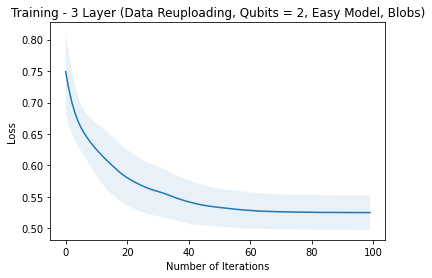

In [15]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 3 Layer (Data Reuploading, Qubits = 2, Easy Model, Blobs)")